# Home Work 4

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from tabulate import tabulate

In [65]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [66]:
# Checking missing value
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [67]:
# Replacing catagorical missing values with 'NA' and numerical missing values with 0.0

for col in df.columns:
    if df[col].dtype == 'object':
        df[col]= df[col].fillna('NA')
    else:
        df[col]= df[col].fillna(0.0)
df
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [68]:
#Split data
df_full_train, df_test = train_test_split(df.drop('converted', axis=1), test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")
df_train

Train size: 935
Validation size: 234
Test size: 293


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
266,events,education,3,61657.0,unemployed,australia,0,0.38
57,social_media,healthcare,2,68420.0,self_employed,europe,3,0.79
908,paid_ads,education,2,41483.0,unemployed,south_america,2,0.85
5,events,manufacturing,1,59904.0,NA,africa,6,0.83
1435,social_media,technology,3,61639.0,student,europe,1,0.27
...,...,...,...,...,...,...,...,...
39,NA,other,5,67314.0,NA,europe,2,0.87
1261,events,education,6,63996.0,NA,australia,4,0.92
595,organic_search,finance,1,73702.0,unemployed,north_america,2,0.55
1329,events,technology,1,93341.0,student,middle_east,4,0.99


# Question 1: ROC AUC feature importance

In [69]:
df_train_num_col= df_train.select_dtypes(include=["int64", "float64"])
df_converted= df['converted'].iloc[df_train.index]

for col in df_train_num_col.columns:
    fpr, tpr, thresholds = roc_curve(df_converted, df_train_num_col[col])
    auc_score = auc(fpr, tpr)
    print(f"{col}: {auc_score}")




number_of_courses_viewed: 0.7656440135120665
annual_income: 0.5523787272567974
interaction_count: 0.7309025242642835
lead_score: 0.6077412069351558


# Question 2: Training the model with One Hot Encoding

In [70]:
numerical_feature=df_train.select_dtypes(include='number').columns.tolist()
categorical_feature=df_train.select_dtypes(include='object').columns.tolist()
features_columns= numerical_feature + categorical_feature

train_records=df_train[features_columns].to_dict(orient='records')
val_records=df_val[features_columns].to_dict(orient='records')
test_records=df_test[features_columns].to_dict(orient='records')


dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_records)
X_val = dv.transform(val_records)
X_test= dv.transform(test_records)

y_train=df.converted.loc[df_train.index].values
y_val=df.converted.loc[df_val.index].values
y_test=df.converted.loc[df_test.index].values

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)


print(f'Validation AUC: {round(auc, 3)}')


Validation AUC: 0.806


# Question 3: Precision and Recall

c:\Users\WALY\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\WALY\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


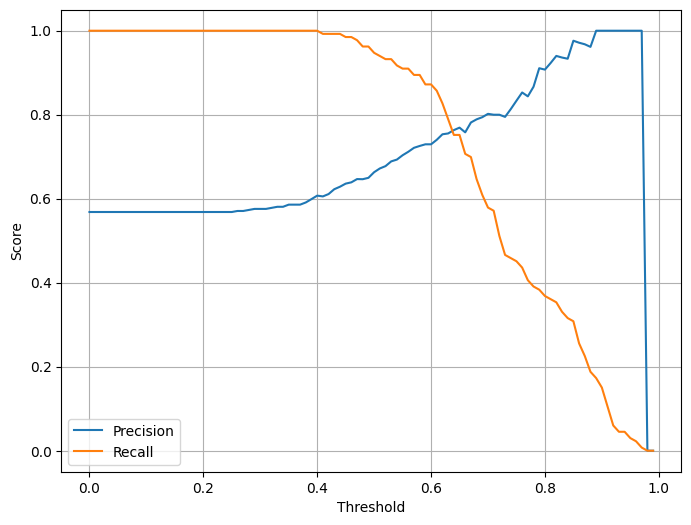

In [71]:
thresholds = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []

for t in  thresholds:
    y_pred_bin = (y_pred >= t)
    precisions.append(precision_score(y_val, y_pred_bin))
    recalls.append(recall_score(y_val, y_pred_bin))

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()



In [72]:
precisions = np.array(precisions)
recalls = np.array(recalls)

difference = precisions - recalls

intersection_indices = np.where(np.diff(np.sign(difference)))[0]

if intersection_indices.size > 0:
    intersection_threshold = (thresholds[intersection_indices] + thresholds[intersection_indices + 1]) / 2
    print(f'Threshold where precision and recall curves intersect: {intersection_threshold[0]:.3f}')
else:
    print('No intersection found within the thresholds.')

Threshold where precision and recall curves intersect: 0.635


# Question 4: F1 score

In [73]:
f1_scores = []

for t in thresholds:
    y_pred_bin = (y_pred >= t)
    p = precision_score(y_val, y_pred_bin)
    r = recall_score(y_val, y_pred_bin)
    if (p + r) == 0:
        f1_scores.append(0)
    else:
        f1_scores.append(2 * p * r / (p + r))

max_idx = np.argmax(f1_scores)
max_threshold = thresholds[max_idx]
max_idx_f1 = f1_scores[max_idx]

print(f"Max F1 score: {max_idx_f1:.3f} at threshold {max_threshold:.3f}")

Max F1 score: 0.801 at threshold 0.580


c:\Users\WALY\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\WALY\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Question 5: 5-Fold CV

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

y_full_train = df_full_train.converted.values
del df_full_train['converted']

# Define KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []

# Perform cross-validation
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(df_train.to_dict(orient='records'))
    X_val = dv.transform(df_val.to_dict(orient='records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

std_auc = np.std(aucs)
print("AUC scores for each fold:", np.round(aucs, 3))
print("Mean AUC:", np.mean(aucs))
print(f"Std deviation of AUC: {std_auc:.3f}")


AUC scores for each fold: [0.806 0.871 0.775 0.802 0.856]
Mean AUC: 0.8221089148573075
Std deviation of AUC: 0.036


# Question 6: Hyperparameter Tuning

In [79]:
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    aucs = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train.to_dict(orient='records'))
        X_val = dv.transform(df_val.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    
    print(f"C={C}: mean={np.mean(aucs):.3f}, std={np.std(aucs):.3f}")


C=1e-06: mean=0.560, std=0.024
C=0.001: mean=0.867, std=0.029
C=1: mean=0.822, std=0.036
